<a href="https://colab.research.google.com/github/EliaTorre/NLP/blob/main/Attention_Is_All_You_Need_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Is All You Need

In [31]:
import random
import math
import time

import spacy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

from torchtext.data.metrics import bleu_score

Downloading Spacy packages

In [32]:
#!python -m spacy download en
#!python -m spacy download de

Initializing the seed to enforce reproducibility of results

In [33]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Loading the spacy modules for German and English

In [34]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

Defining the tokenizer functions

In [35]:
def deutsch_tokenizer(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def english_tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

Through pytorch's Field function I appended "sos" and "eos" tokens at the beginning and end of the sentences and transformed all of the sentences' words to lowercase

In [36]:
DE = Field(tokenize = deutsch_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)
EN = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first = True)

I downloaded the Multi30K dataset which contains the parallel german-english-french tranlsation of approx. 30k sentences with approx. 12 words per sentence each. I used torchtext.datasets split attribute to divide the dataset in train/validation/test, where "exts" attribute specifies which language to use as source and which to use as target

In [37]:
train_data, validation_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (DE, EN))

I proceed in building the german (DE) and english (EN) vocabularies from the training data enforcing that only words which appear at least twice are included, otherwise an "UNK" token is put in their place

In [38]:
DE.build_vocab(train_data, min_freq = 2)
EN.build_vocab(train_data, min_freq = 2)

I defined the device such that GPU can be exploited to speed up the training

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I define the iterators with a batch of 128, such that the data is transformed to an iterable object with a source and target attribute that maps tokenized words to their index in the vocabulary. I used "BucketIterator" instead of the standard "Iterator" because it creates batches that minimize the padding within sentences, such that it speeds up computation

In [40]:
BATCH = 128
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = BATCH, device = device)

The structure of the Transformer follows the encoder - decoder architecture. However, it aims at avoiding the compression of the source sentence in a context vector. Indeed, it creates a sequence of context vectors, i.e., one context vector for each token within the source sentence. Each of which is evaluated conditional on knowing each token at all positions in the input sequence.

In order to do so, the embedded source sentence is multiplied by a scaling factor "sqrt(hidden_dim") and elementwise summed with a "positional embedding", i.e., a vocabulary of indexes matching tokens to their position in the sentence. A dropout layer is then performed on the combined embeddings.

In this regard, I applied a slight variation to the paper. Indeed, the paper is exploiting a fixed static embedding. Here, a positional embedding layer is exploited to obtain an implementation similar to the state-of-the-art BERT architecture. 

The combined embedding is then passed through the encoder layers to obtain the sequence of context vectors. In addition, "de_mask" is defined to identify the padding tokens, as they will be ignored in the attention mechanism. 

In [41]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, layers, heads, feed_dim, dropout, device, max = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max, hidden_dim)
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, heads, feed_dim, dropout, device) for _ in range(layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self, de, de_mask):
        batch = de.shape[0]
        de_len = de.shape[1]
        pos = torch.arange(0, de_len).unsqueeze(0).repeat(batch, 1).to(self.device)
        de = self.dropout((self.tok_embedding(de) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            de = layer(de, de_mask)
            
        return de

Following the paper, the standard RNN layer of Encoder-Decoder architecture is replaced by a "MultiHeadAttentionLayer". In the "EncoderLayer", the source sentence and its mask are the impout of the MultiHeadAttention, then dropout and layer normalization are performed and the outcome is fed to the "position-wise feedforward" layer. Finally dropout and layer normalization are applied again before feeding the output to the next layer.

In particular, the normalization layer aims at normalizing the features across the hidden layers to a mean of 0 and std of 1

In [42]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, heads, feed_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, feed_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, de, de_mask):
        _de, _ = self.self_attention(de, de, de, de_mask)
        de = self.self_attn_layer_norm(de + self.dropout(_de))
        _de = self.positionwise_feedforward(de)
        de = self.ff_layer_norm(de + self.dropout(_de))

        return de

MultiHeadAttention represent the core innovation brought by Transformers. Attention is defined through "queries", "key" and "values", according to the following scheme:

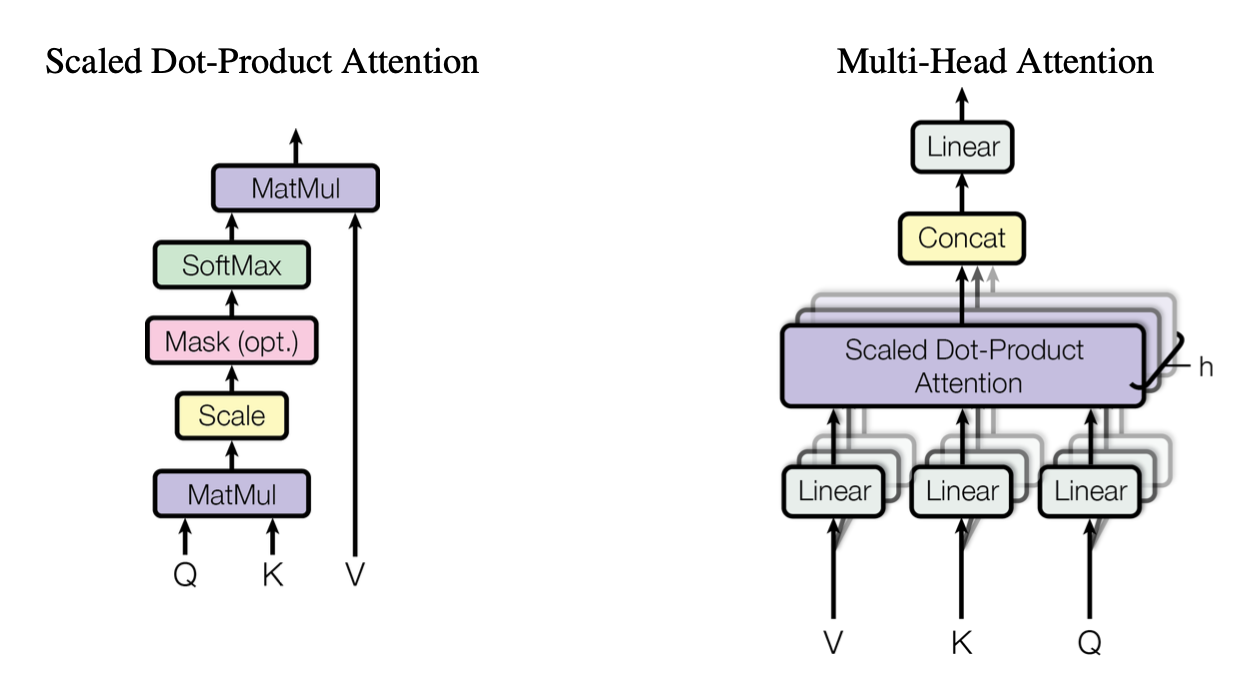

The Scaled Dot-Product Attention is performed by taking the dot product of "query" and "key", applying Softmax and scaling by "head_dim". Finally, it multiplies by "value". 

However, the transformer is not simply computing the Scaled Dot-Product, indeed it performs multiple parallel evaluations of the attention through the Multi-Head Attention: it splits "hidden_dim" into # "heads" and computes the Scaled Dot-Product over all these samples, the obtained attentions are then concatenated and weighted by "fc_o" to obtain the "multi_head"

In [43]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, heads, dropout, device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.heads = heads
        self.head_dim = hidden_dim // heads
        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        batch = query.shape[0]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        Q = Q.view(batch, -1, self.heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch, -1, self.heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch, -1, self.heads, self.head_dim).permute(0, 2, 1, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        multi_head = torch.matmul(self.dropout(attention), V)
        multi_head = multi_head.permute(0, 2, 1, 3).contiguous()
        multi_head = multi_head.view(batch, -1, self.hidden_dim)        
        multi_head = self.fc_o(multi_head)
        
        return multi_head, attention

The PositionWiseFeedForwardLayer transforms the "hidden_dim" in "ff_dim" and applies ReLU and Dropout to it. In doing so, the size of the vector is reshaped, indeed our "hidden_dim" is 256, while "ff_dim" is 512. This is a signficantly smaller than the paper sizes to maintain training times fast, indeed the paper uses a "hidden_dim" of 512 and a "ff_dim" of 2048. 

For what concerns the ReLU activation, it is not specified the purpose of its application, while BERT uses GeLU activation, I decided to not deviate in this regard because I am not fully aware of how this change would affect the architecture of my model

In [44]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, feed_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hidden_dim, feed_dim)
        self.fc_2 = nn.Linear(feed_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))        
        x = self.fc_2(x)

        return x

The Decoder works similarly to the Encoder, except that it now has two multi-head attention layers. A masked multi-head attention layer over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value. 

The decoder uses positional embedding and combines - via elementwise sum - them with the scaled embedded target tokens, followed by dropout. 

The combined embedding are then passed through the decoder layers, along with "enc_de", "en_mask" and "de_mask". The final decoder representation is passed through a linear layer and a softmax is later applied within the loss_function

In [45]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, layers, heads, feed_dim, dropout, device, max = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max, hidden_dim)
        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, heads, feed_dim, dropout, device) for _ in range(layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self, en, enc_de, en_mask, de_mask):
        batch = en.shape[0]
        en_len = en.shape[1]  
        pos = torch.arange(0, en_len).unsqueeze(0).repeat(batch, 1).to(self.device)
        en = self.dropout((self.tok_embedding(en) * self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
            en, attention = layer(en, enc_de, en_mask, de_mask)

        output = self.fc_out(en)

        return output, attention

The two multi-head attention layers in the Decoder are represented by "self_attention" and "encoder_attention". 

"self_attention" is evaluated in the Decoder on the target sequence as in the Encoder with source sequence, except for the introduction of "en_mask" to enforce causality.

The second attention is evaluated by feeding the "enc_de" sequence to the decoder. The decoder representation act as queries, while the encoder representation fulfill keys and values roles. A mask to avoid "pad" tokens is enforced and then a dropout, residual connection and normalization layers are applied. The output is fed to the "positionwise_feedforward" layer and a new set of dropout and normalization layer are applied. 

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, heads, feed_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, feed_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, en, enc_de, en_mask, de_mask):
        _en, _ = self.self_attention(en, en, en, en_mask)
        en = self.self_attn_layer_norm(en + self.dropout(_en))
        _en, attention = self.encoder_attention(en, enc_de, enc_de, de_mask)
        en = self.enc_attn_layer_norm(en + self.dropout(_en))
        _en = self.positionwise_feedforward(en)
        en = self.ff_layer_norm(en + self.dropout(_en))
        
        return en, attention

Finally, the Seq2Seq class is created, it takes care of the definition of masks and combines the encoder and decoder in the final transformer architecture.

After the masks are created, the forward method is fed with "de" and "en" sequences, it defines the masks, obtains the encoded source by the encoder, and runs the decoder to obtain the final predicted "outputs" along with a vectorized attention over the source sequence

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, de_pad_idx, en_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.de_pad_idx = de_pad_idx
        self.en_pad_idx = en_pad_idx
        self.device = device
        
    def make_de_mask(self, de):
        de_mask = (de != self.de_pad_idx).unsqueeze(1).unsqueeze(2)
        return de_mask
    
    def make_en_mask(self, en):
        en_pad_mask = (en != self.en_pad_idx).unsqueeze(1).unsqueeze(2)
        en_len = en.shape[1]
        en_sub_mask = torch.tril(torch.ones((en_len, en_len), device = self.device)).bool()
        en_mask = en_pad_mask & en_sub_mask
        return en_mask

    def forward(self, de, en):
        de_mask = self.make_de_mask(de)
        en_mask = self.make_en_mask(en)
        enc_de = self.encoder(de, de_mask)
        output, attention = self.decoder(en, enc_de, en_mask, de_mask)
        return output, attention

Here I define the parameters of encoder and decoder. It happens to be significantly smaller compared to the one described in the paper such that it can be easily run on a single GPU.

In [48]:
input_dim, output_dim, hidden_dim = len(DE.vocab), len(EN.vocab), 256
encoder_layers, decoder_layers = 3, 3
encoder_heads, decoder_heads = 8, 8
encoder_feed_dim, decoder_feed_dim = 512, 512
encoder_dropout, decoder_dropout = 0.1, 0.1

encoder = Encoder(input_dim, hidden_dim, encoder_layers, encoder_heads, encoder_feed_dim, encoder_dropout, device)
decoder = Decoder(output_dim, hidden_dim, decoder_layers, decoder_heads, decoder_feed_dim, decoder_dropout, device)

Then, the Seq2Seq model is defined:

In [49]:
de_pad_idx = DE.vocab.stoi[DE.pad_token]
en_pad_idx = EN.vocab.stoi[EN.pad_token]
model = Seq2Seq(encoder, decoder, de_pad_idx, en_pad_idx, device).to(device)

We can notice that the model's parameter number is signficantly smaller compared to both of the other implementations. 

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


No indication of weight initialization of the parameters is provided in the paper. However, searching a bit around the internet, it seems like "xavier_uniform" is common-use in the field:

In [51]:
def weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(weights);

For what concerns the optimization technique I applied another slight variation to the paper, which uses a "warm-up" and "cool-down" approach based on ADAM, while the BERT implementation exploits a fixed learning-rate. The paper optimization schedule is the following: 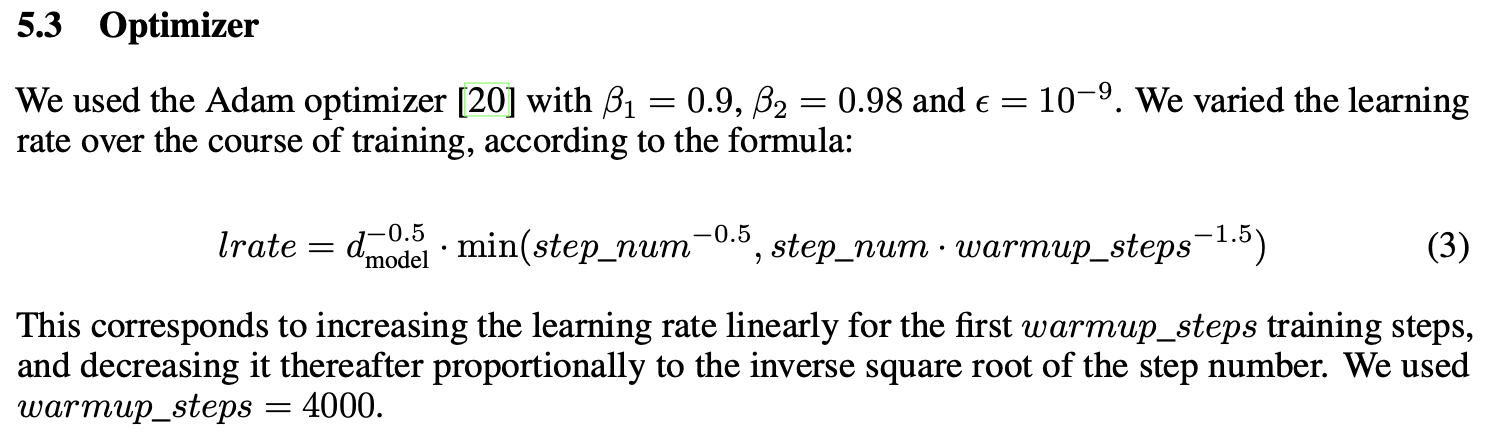

For what concerns the "loss_function" we stick to the "CrossEntropyLoss" used in the previous notebooks

In [52]:
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_function = nn.CrossEntropyLoss(ignore_index = en_pad_idx)

Next, I define the functions "train" and "test". 

In the first one, I am setting "model.train()" such that dropout layer is considered when running the model. It iterates over the data iterator to update the parameters of the model: 
- Gets the german and english sentences.
- Set to zero the gradients calculated previously.
- Runs the model to obtain the predictions. 
- It reshapes input and output through .view() to fit the loss function. 
- Performs backpropagation and clips the gradient to avoind exploding gradients problems.
- Updates the parameters through optimizer.step() 
- Updates epoch_loss

Then it returns the epoch_loss averaged over all batches. 

In [53]:
def train(model, iterator, optimizer, loss_function, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        de = batch.src
        en = batch.trg
        optimizer.zero_grad()
        output, _ = model(de, en[:,:-1])  
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        en = en[:,1:].contiguous().view(-1)
        loss = loss_function(output, en)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The "test" function works similarly to the "train" function, however in this case, I set model.eval() such that no parameter optimization and dropout is performed.
Furthermore, torch.no_grad() is introduced to avoid the computational cost of performing the gradients calculation.

In [54]:
def test(model, iterator, loss_function):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            de = batch.src
            en = batch.trg
            output, _ = model(de, en[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            en = en[:,1:].contiguous().view(-1)
            loss = loss_function(output, en)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

The following "translate" function has the purpose of generating a translation of the german text and it is needed to evaluate the model according to the BLEU score

In [55]:
def translate(sentence, de_field, en_field, model, device, max = 50):
    model.eval()
    tokens = [token.lower() for token in sentence]
    tokens = [de_field.init_token] + tokens + [de_field.eos_token]
    de_idx = [de_field.vocab.stoi[token] for token in tokens]
    de_tensor = torch.LongTensor(de_idx).unsqueeze(0).to(device)
    de_mask = model.make_de_mask(de_tensor)
    
    with torch.no_grad():
        enc_de = model.encoder(de_tensor, de_mask)

    en_idx = [en_field.vocab.stoi[en_field.init_token]]

    for i in range(max):
        en_tensor = torch.LongTensor(en_idx).unsqueeze(0).to(device)
        en_mask = model.make_en_mask(en_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(en_tensor, enc_de, en_mask, de_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        en_idx.append(pred_token)

        if pred_token == en_field.vocab.stoi[en_field.eos_token]:
            break
    
    en_tokens = [en_field.vocab.itos[i] for i in en_idx]
    
    return en_tokens[1:], attention

In [56]:
def bleu(data, de_field, en_field, model, device, max = 50):
    ens = []
    pred_ens = []
    
    for x in data:
        de = vars(x)['src']
        en = vars(x)['trg']
        pred_en, _ = translate(de, de_field, en_field, model, device, max)
        pred_en = pred_en[:-1]
        pred_ens.append(pred_en)
        ens.append([en])
        
    return bleu_score(pred_ens, ens)

In [57]:
def count_time(start, end):
    elapsed = end - start
    mins = int(elapsed / 60)
    secs = int(elapsed - (mins * 60))
    return mins, secs

In [58]:
epochs, clip, best = 10, 1, float('inf')

for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss = test(model, validation_iterator, loss_function)
    end = time.time()
    mins, secs = count_time(start, end)
    
    if validation_loss < best:
        best = validation_loss
        torch.save(model.state_dict(), 'Transformer-model.pt')
    
    print(f'Epoch: {epoch + 1}, Time: {mins}m {secs}s')
    print(f'Train Loss: {train_loss:.3f}, Validation Loss: {validation_loss:.3f} ')
    print(f'Train PPL: {math.exp(train_loss):7.3f}, Validation PPL: {math.exp(validation_loss):7.3f}\n')

Epoch: 1, Time: 0m 15s
Train Loss: 4.220, Validation Loss: 3.021 
Train PPL:  68.055, Validation PPL:  20.520

Epoch: 2, Time: 0m 15s
Train Loss: 2.811, Validation Loss: 2.303 
Train PPL:  16.630, Validation PPL:   9.999

Epoch: 3, Time: 0m 15s
Train Loss: 2.234, Validation Loss: 1.980 
Train PPL:   9.339, Validation PPL:   7.240

Epoch: 4, Time: 0m 15s
Train Loss: 1.885, Validation Loss: 1.798 
Train PPL:   6.583, Validation PPL:   6.040

Epoch: 5, Time: 0m 15s
Train Loss: 1.639, Validation Loss: 1.711 
Train PPL:   5.150, Validation PPL:   5.536

Epoch: 6, Time: 0m 15s
Train Loss: 1.447, Validation Loss: 1.666 
Train PPL:   4.251, Validation PPL:   5.292

Epoch: 7, Time: 0m 15s
Train Loss: 1.294, Validation Loss: 1.631 
Train PPL:   3.647, Validation PPL:   5.109

Epoch: 8, Time: 0m 15s
Train Loss: 1.167, Validation Loss: 1.625 
Train PPL:   3.212, Validation PPL:   5.077

Epoch: 9, Time: 0m 15s
Train Loss: 1.060, Validation Loss: 1.625 
Train PPL:   2.886, Validation PPL:   5.077

E

In [59]:
model.load_state_dict(torch.load('Transformer-model.pt'))
test_loss = test(model, test_iterator, loss_function)
print(f'Test Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):7.3f}')

Test Loss: 1.679, Test PPL:   5.360


In [60]:
bleu_score = bleu(test_data, DE, EN, model, device)
print(f'BLEU score: {bleu_score*100:.2f}')

BLEU score: 35.72
